In [1]:
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../../../AutexysHost/source')

from utilities import DataLoggerUtility as dlu
from utilities import DataPlotterUtility as dpu
from utilities import FET_Modeling as fet_model
from procedures import Device_History as DH
from procedures import AFM_Control as afm_ctrl
import launcher
import defaults

from matplotlib import pyplot as plt
import numpy as np

import scipy.optimize as sci_opt

saveFolder = '../../../Publications/2018-04-30 Bias Stress ACS/Plots'

# %config InlineBackend.figure_format = 'svg'

In [43]:
experimentNumbers = list(range(75,87+1))

heightSeq = []

for experimentNumber in experimentNumbers:
    e = {}
    
    dh = dlu.loadSpecificDeviceHistory('../../AutexysData/jay/MoS2FET/JM4/C/27-30/', 'AFMControl.json', minExperiment=experimentNumber, maxExperiment=experimentNumber)
    
    traces = afm_ctrl.extractTraces(dh)
    traceNumber = 0
    
    Vx_vals = traces['Vx'][traceNumber]
    Vy_vals = traces['Vy'][traceNumber]
    Id_vals = traces['Id'][traceNumber]
    
    sgm_matrix, sgmWidth, sgmHeight = afm_ctrl.getRasteredMatrix(Vx_vals, Vy_vals, Id_vals)
    sgm_matrix = afm_ctrl.interpolate_nans(sgm_matrix)
    
    e['sgm_matrix'] = sgm_matrix*1e9
    e['sgmWidth'] = sgmWidth
    e['sgmHeight'] = sgmHeight
    e['runParams'] = dh[0]['runConfigs'][dh[0]['runType']]
    
    heightSeq.append(e)


ValueError: array of sample points is empty

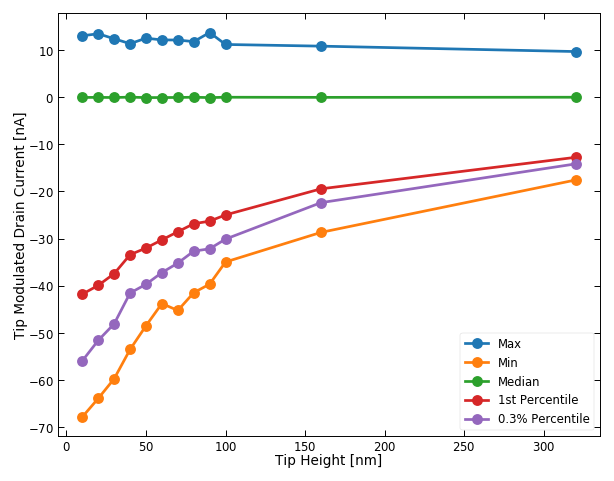

In [55]:
plt.figure(figsize=(5,4), dpi=140)

heights = [e['runParams']['NapHeight[nm]'] for e in heightSeq]
maxIds = [np.max(e['sgm_matrix']) for e in heightSeq]
minIds = [np.min(e['sgm_matrix']) for e in heightSeq]
medianIds = [np.median(e['sgm_matrix']) for e in heightSeq]
percentile1Ids = [np.percentile(e['sgm_matrix'], 1) for e in heightSeq]
percentile03Ids = [np.percentile(e['sgm_matrix'], 0.3) for e in heightSeq]

plt.plot(heights, maxIds, 'o-', label='Max')
plt.plot(heights, minIds, 'o-', label='Min')
plt.plot(heights, medianIds, 'o-', label='Median')
plt.plot(heights, percentile1Ids, 'o-', label='1st Percentile')
plt.plot(heights, percentile03Ids, 'o-', label='0.3% Percentile')

plt.xlabel('Tip Height [nm]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend()
plt.show()

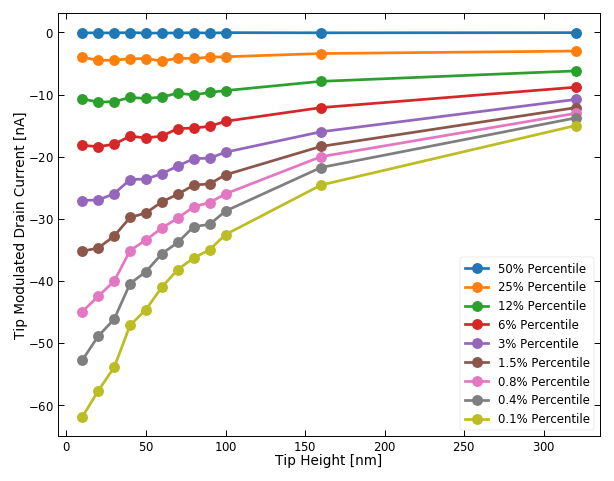

In [59]:
plt.figure(figsize=(5,4), dpi=140)

heights = [e['runParams']['NapHeight[nm]'] for e in heightSeq]

for percentile in reversed([0.1, 0.4, 0.8, 1.5, 3, 6, 12, 25, 50]):
    percentileIds = [np.percentile(e['sgm_matrix'], percentile) for e in heightSeq]
    plt.plot(heights, percentileIds, 'o-', label='{}% Percentile'.format(percentile))

plt.xlabel('Tip Height [nm]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend()
plt.show()

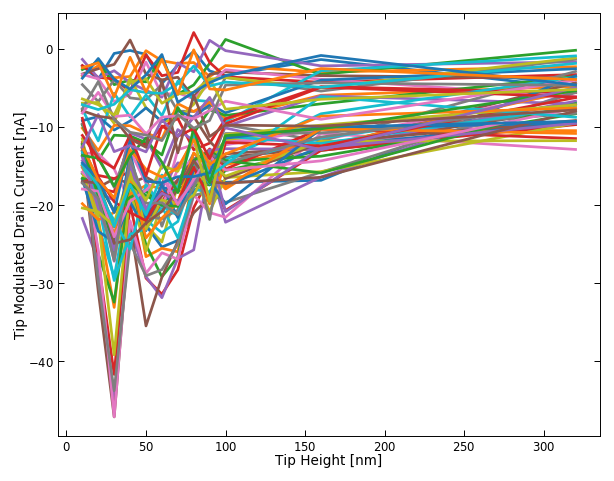

In [70]:
plt.figure(figsize=(5,4), dpi=140)

minRows = min([e['sgm_matrix'].shape[0] for e in heightSeq])
minCols = min([e['sgm_matrix'].shape[1] for e in heightSeq])

for row in range(minRows):
    pointIds = [e['sgm_matrix'][row][256] for e in heightSeq]
    plt.plot(heights, pointIds)

plt.xlabel('Tip Height [nm]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

In [71]:
minRows = min([e['sgm_matrix'].shape[0] for e in heightSeq])
minCols = min([e['sgm_matrix'].shape[1] for e in heightSeq])

maxRows = max([e['sgm_matrix'].shape[0] for e in heightSeq])
maxCols = max([e['sgm_matrix'].shape[1] for e in heightSeq])

print(minRows, maxRows, minCols, maxCols)

62 64 516 524


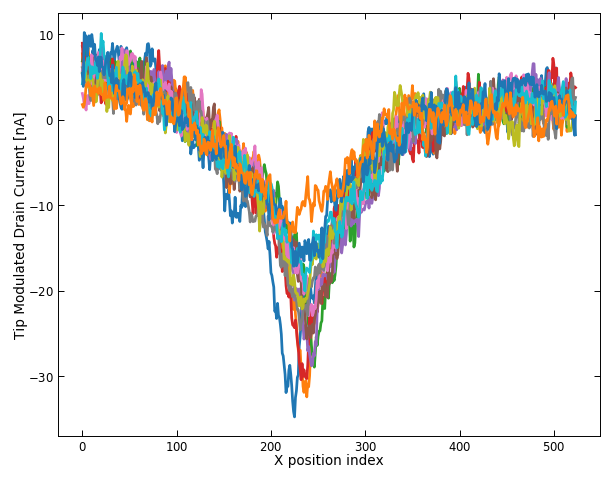

In [72]:
plt.figure(figsize=(5,4), dpi=140)

for e in heightSeq:
    pointIds = e['sgm_matrix'][32]
    plt.plot(pointIds)

plt.xlabel('X position index')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

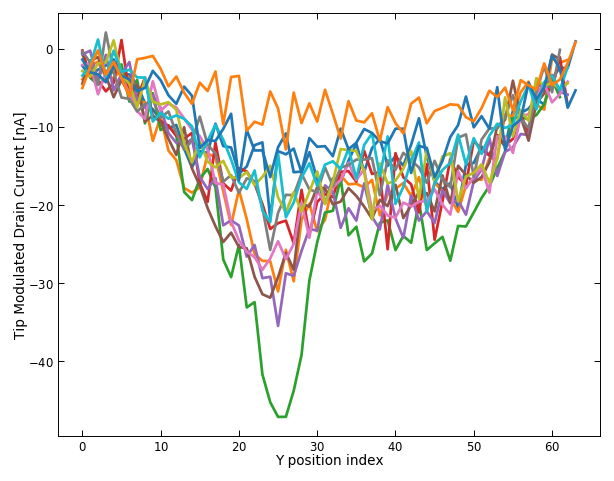

In [75]:
plt.figure(figsize=(5,4), dpi=140)

for e in heightSeq:
    pointIds = e['sgm_matrix'][:,256]
    plt.plot(pointIds)

plt.xlabel('Y position index')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

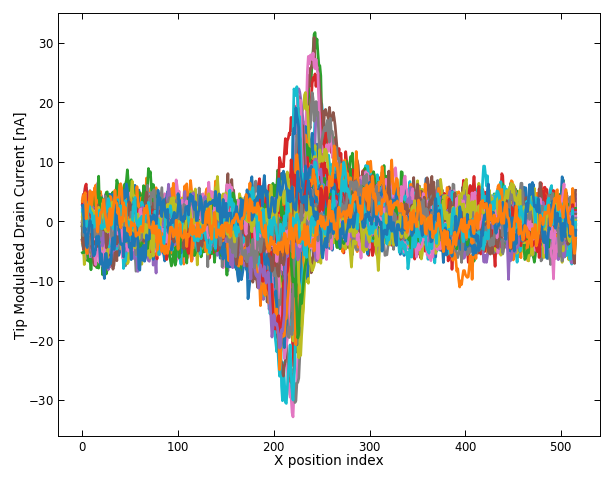

In [92]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(minRows):
    offset = 0
    pointIds = heightSeq[0]['sgm_matrix'][row][0:minCols-offset] - heightSeq[1]['sgm_matrix'][row][offset:minCols]
    plt.plot(pointIds)

plt.xlabel('X position index')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

In [276]:
def rowDiff(row1, row2, offset, compareLength):
    if offset >= 0:
        return row1[offset:offset+compareLength] - row2[0:compareLength]
    else:
        return row1[0:compareLength] - row2[abs(offset):abs(offset)+compareLength]

def rowDiffSquaredError(row1, row2, offset, compareLength):
    return np.sum(np.array(rowDiff(row1, row2, offset, compareLength))**2)

def rowOffsetsAndErrors(row1, row2, maxOffsetPercent):
    maxLength = max(len(row1), len(row2))
    minLength = min(len(row1), len(row2))
    
    maxOffset = int(maxOffsetPercent/100*minLength)
    compareLength = minLength - maxOffset
    
    offsets = list(range(-maxOffset, maxOffset+1))
    errors = [rowDiffSquaredError(row1, row2, offset, compareLength) for offset in offsets]
    
    return np.array(offsets), np.array(errors)

def bestRowXOffsetAndError(row1, row2, maxOffsetPercent):
    offsets, errors = rowOffsetsAndErrors(row1, row2, maxOffsetPercent)
    
    offsets = np.array(offsets)
    errors = np.array(errors)
    
    # Only accept the offset if it reduces the error to less than half of what it was with no offset
    if min(errors)/errors[np.argmin(offsets)] < 0.5:
        offset = offsets[np.argmin(errors)]
    else:
        offset = 0.0
    
    error = errors[offsets == offset][0]
    
    return offset, error

def bestXOffsetsAndErrors(m1, m2, maxOffsetPercent):
    # get offsets of m2 by comparisson to m1
    minRows = min(len(m1), len(m2))
    offsetsAndErrors = [bestRowXOffsetAndError(m1[row], m2[row], 5) for row in range(minRows)]
    offsetsAndErrors = np.array(offsetsAndErrors)
    
    offsets = offsetsAndErrors[:,0]
    errors = offsetsAndErrors[:,1]
    
    return offsets, errors

def applyXOffsetsToMatrix(m, xoffsets, width=0):
    xoffsetsAbsolute = np.array(xoffsets)
    if min(xoffsets) < 0:
        xoffsetsAbsolute -= min(xoffsets)
    
    rows = m.shape[0]
    cols = m.shape[1] + int(max(xoffsetsAbsolute))
    cols = max(cols, width)
    
    mnew = np.zeros((rows, cols))*np.nan
    
    for row in range(len(xoffsetsAbsolute)):
        offset = int(xoffsetsAbsolute[row])
        mnew[row][offset:m.shape[1]+offset] = m[row]
    
    return mnew

def alignMatrixes(matrixes, masterIndex=0, sequential=True, maxOffsetPercent=5, trimX=True):
    minRows = min([m.shape[0] for m in matrixes])
    
    allOffsets = np.zeros((len(matrixes), minRows))
    
    for i in range(masterIndex + 1, len(matrixes)):
        offsets, errors = bestXOffsetsAndErrors(matrixes[i-1], matrixes[i], maxOffsetPercent)
        allOffsets[i] = allOffsets[i-1] + offsets[0:minRows]
    
    for i in range(masterIndex - 1, 0 - 1, -1):
        offsets, errors = bestXOffsetsAndErrors(matrixes[i+1], matrixes[i], maxOffsetPercent)
        allOffsets[i] = allOffsets[i+1] + offsets[0:minRows]
    
    allOffsets -= np.min(allOffsets)
    maxWidths = [matrixes[i].shape[1] + np.max(allOffsets[i]) for i in range(len(matrixes))]
    minWidths = [matrixes[i].shape[1] + np.min(allOffsets[i]) for i in range(len(matrixes))]
    maxCols = int(max(maxWidths))
    
    startTrimX = int(np.max(allOffsets))
    endTrimX = int(np.min(minWidths))
    
    alignedMatrices = []
    for i in range(len(matrixes)):
        m = applyXOffsetsToMatrix(matrixes[i], allOffsets[i], width=maxCols)
        
        if trimX:
            m = m[:,startTrimX:endTrimX]
        
        alignedMatrices.append(m[0:minRows])
    
    return alignedMatrices

def makeDataCube(matrices):
    widths =  [m.shape[0] for m in matrices]
    heights = [m.shape[1] for m in matrices]
    
    rows = min(widths)
    cols = min(heights)
    
    dataCube = np.zeros((len(matrices), rows, cols))
    
    for i in range(len(matrices)):
        dataCube[i] = matrices[i][0:rows,0:cols]
    
    return dataCube

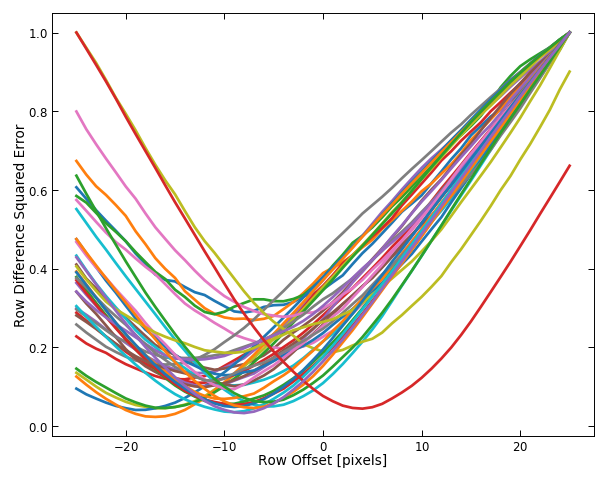

In [163]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(15,50):
    offsets, errors = rowOffsetsAndErrors(heightSeq[0]['sgm_matrix'][row], heightSeq[1]['sgm_matrix'][row], 5)
    plt.plot(offsets, errors/max(errors))

plt.xlabel('Row Offset [pixels]')
plt.ylabel('Row Difference Squared Error')
plt.show()

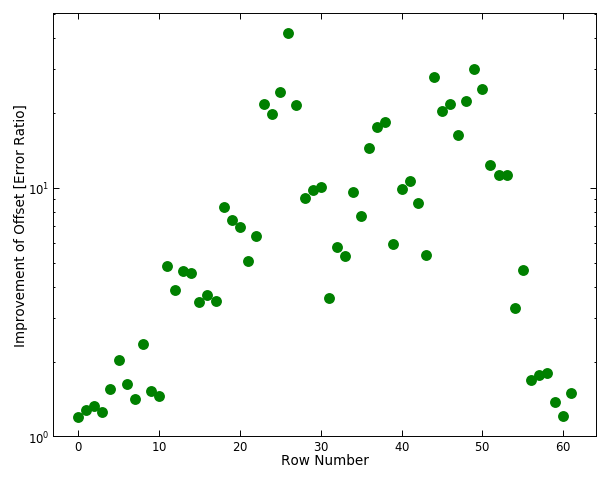

In [164]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(minRows):
    offsets, errors = rowOffsetsAndErrors(heightSeq[0]['sgm_matrix'][row], heightSeq[1]['sgm_matrix'][row], 5)
    plt.semilogy(row, max(errors)/min(errors), 'go')

plt.xlabel('Row Number')
plt.ylabel('Improvement of Offset [Error Ratio]')
plt.show()

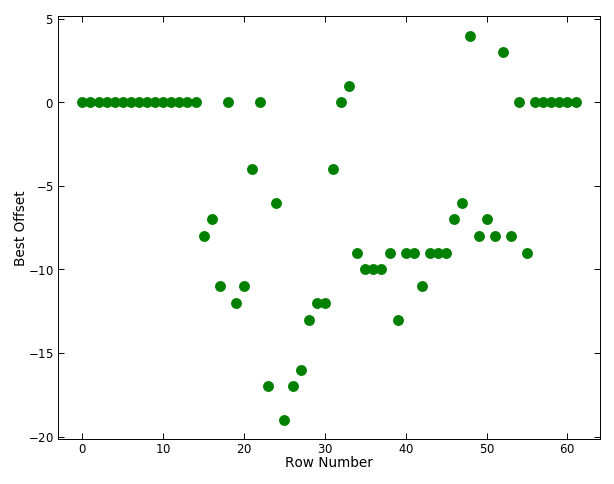

In [184]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(minRows):
    offset, error = bestRowXOffsetAndError(heightSeq[0]['sgm_matrix'][row], heightSeq[1]['sgm_matrix'][row], 5)
    plt.plot(row, offset, 'go')

plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

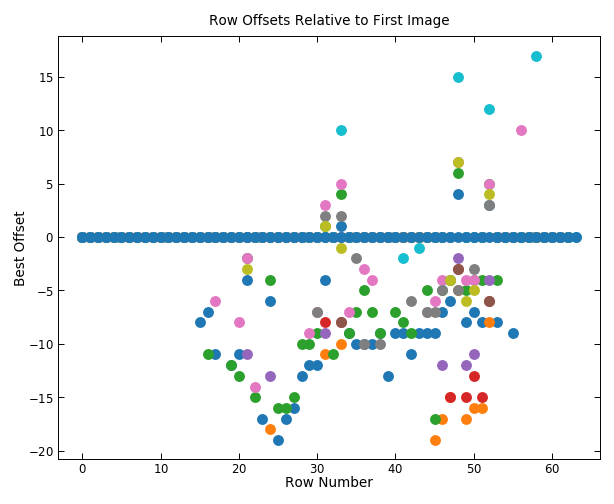

In [201]:
plt.figure(figsize=(5,4), dpi=140)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[0]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    plt.plot(offsets, 'o')

plt.title('Row Offsets Relative to First Image')
plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

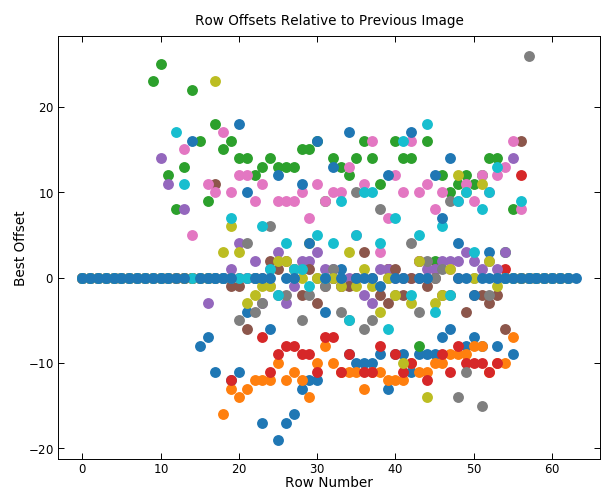

In [202]:
plt.figure(figsize=(5,4), dpi=140)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[i-1]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    plt.plot(offsets, 'o')

plt.title('Row Offsets Relative to Previous Image')
plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

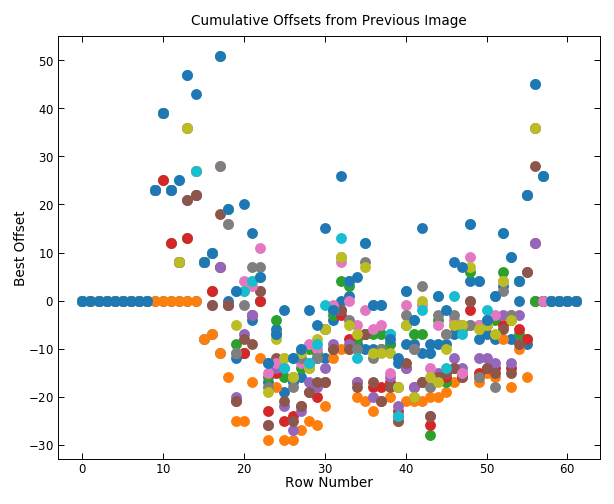

In [203]:
plt.figure(figsize=(5,4), dpi=140)

cumulativeOffsets = np.zeros(minRows)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[i-1]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    cumulativeOffsets += offsets[0:minRows]
    plt.plot(cumulativeOffsets, 'o')

plt.title('Cumulative Offsets from Previous Image')
plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

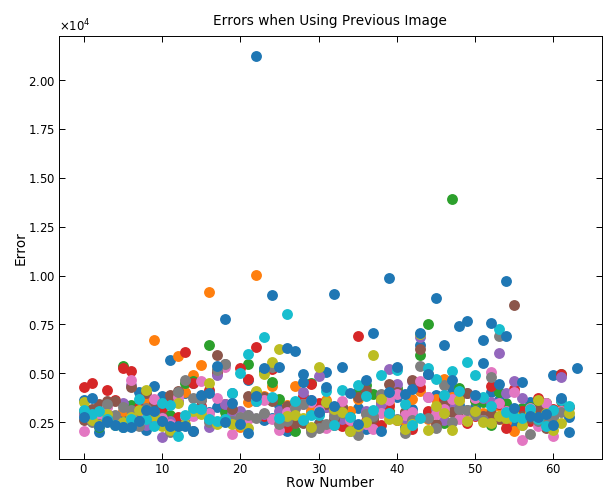

In [205]:
plt.figure(figsize=(5,4), dpi=140)

cumulativeOffsets = np.zeros(minRows)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[i-1]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    plt.plot(errors, 'o')

plt.title('Errors when Using Previous Image')
plt.xlabel('Row Number')
plt.ylabel('Error')
plt.show()

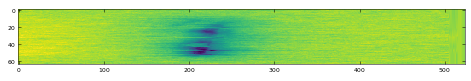

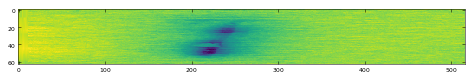

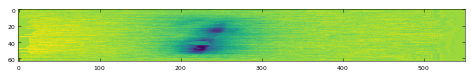

In [228]:
offsets, errors = bestXOffsetsAndErrors(heightSeq[1]['sgm_matrix'], heightSeq[0]['sgm_matrix'], 5)
m = applyXOffsetsToMatrix(heightSeq[0]['sgm_matrix'], offsets)

plt.imshow(heightSeq[0]['sgm_matrix'])
plt.show()

plt.imshow(heightSeq[1]['sgm_matrix'])
plt.show()

plt.imshow(m)
plt.show()

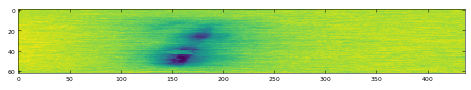

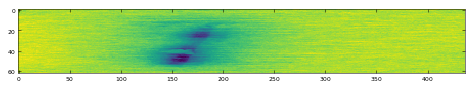

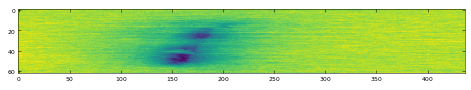

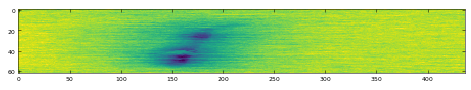

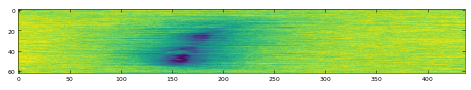

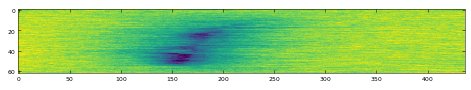

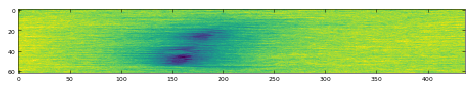

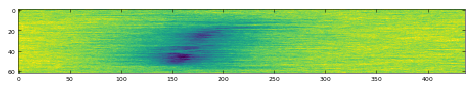

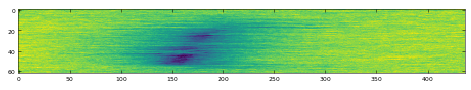

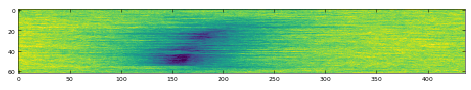

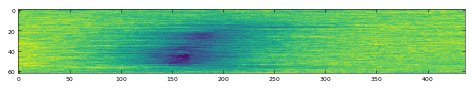

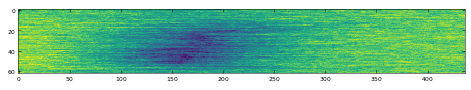

In [277]:
matrices = [e['sgm_matrix'] for e in heightSeq]

alignedMatrices = alignMatrixes(matrices, masterIndex=1)
heightSeqCube = makeDataCube(alignedMatrices)

for am in alignedMatrices:
    plt.imshow(am)
    plt.show()

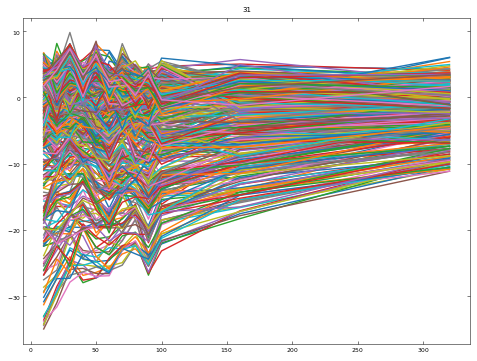

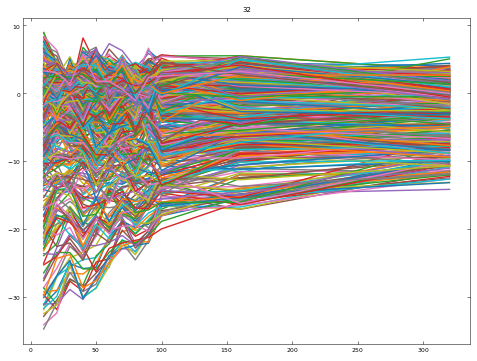

In [400]:
matrices = [e['sgm_matrix'] for e in heightSeq]

alignedMatrices = alignMatrixes(matrices, masterIndex=1)
heightSeqCube = makeDataCube(alignedMatrices)

for r in range(31,33):
    for c in range(heightSeqCube.shape[2]):
        plt.plot(heights, heightSeqCube[:,r,c])
    
    plt.title(r)
    plt.show()

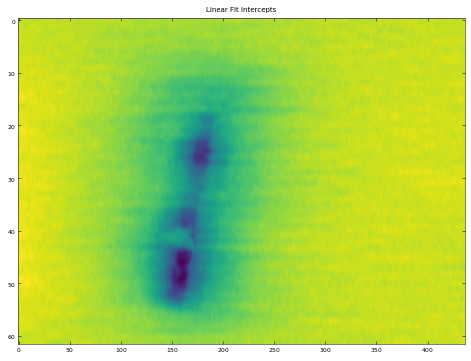

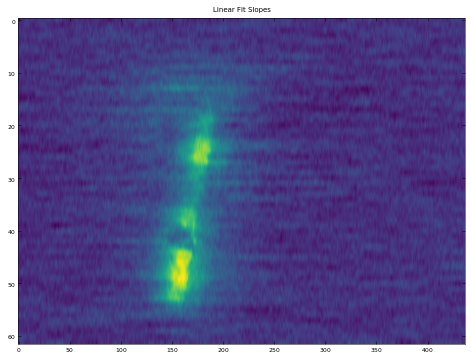

In [290]:
linearFitIntercepts = np.zeros(heightSeqCube[0].shape)
linearFitSlopes = np.zeros(heightSeqCube[0].shape)

for r in range(heightSeqCube.shape[1]):
    for c in range(heightSeqCube.shape[2]):
        ps = np.polyfit(heights, heightSeqCube[:,r,c], 1)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]

plt.title('Linear Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

plt.title('Linear Fit Slopes')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

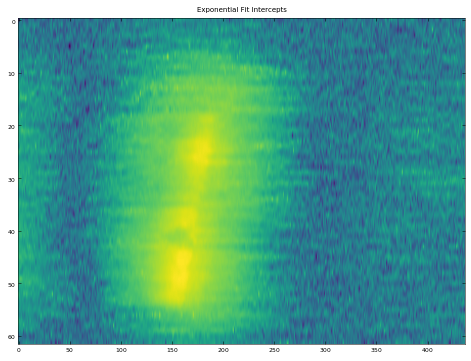

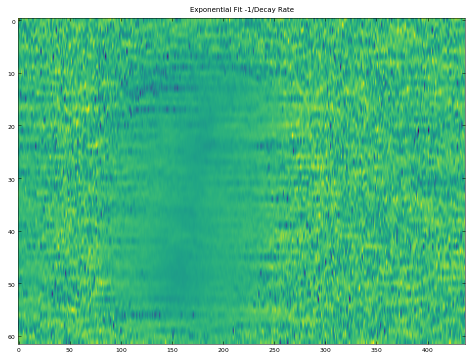

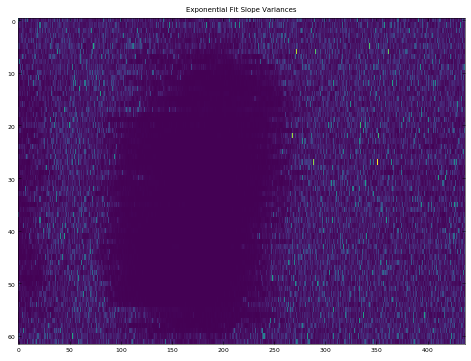

In [390]:
linearFitIntercepts = np.zeros(heightSeqCube[0].shape)
linearFitSlopes = np.zeros(heightSeqCube[0].shape)
linearFitSlopeVariances = np.zeros(heightSeqCube[0].shape)

for r in range(heightSeqCube.shape[1]):
    for c in range(heightSeqCube.shape[2]):
        ps, V = np.polyfit(heights, np.log(np.abs(heightSeqCube[:,r,c])), 1, cov=True)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]
        linearFitSlopeVariances[r,c] = V[0][0]

plt.title('Exponential Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

# linearFitSlopes = -1/linearFitSlopes
# linearFitSlopes[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = 0
# linearFitSlopes[linearFitSlopes > np.percentile(linearFitSlopes, 50)] = np.mean(linearFitSlopes)

plt.title('Exponential Fit -1/Decay Rate')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

# linearFitSlopeVariances[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = np.nan

plt.title('Exponential Fit Slope Variances')
plt.imshow(linearFitSlopeVariances, aspect='auto')
plt.show()

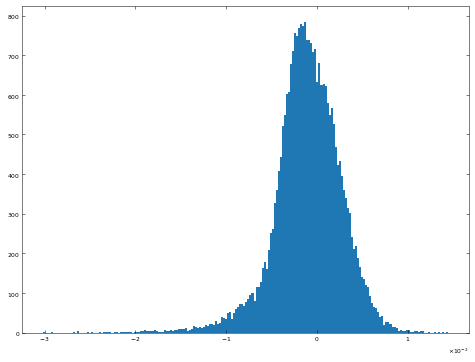

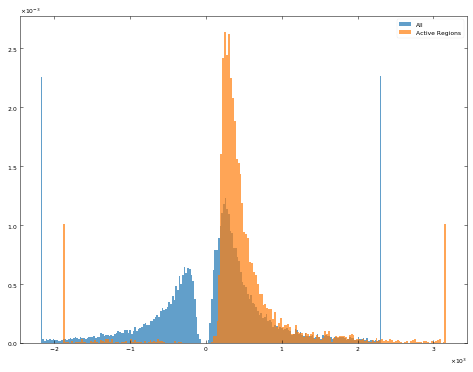

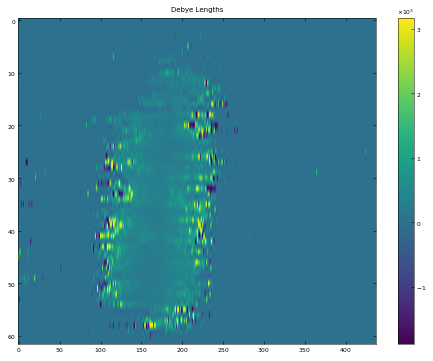

In [394]:
debyeLengths = -1/linearFitSlopes
debyeLengths[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = 0
debyeLengths = np.clip(debyeLengths, np.percentile(debyeLengths, 0.5), np.percentile(debyeLengths, 99.5))

debyeLengths2 = -1/linearFitSlopes
# debyeLengths2[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 40)] = 0
debyeLengths2 = np.clip(debyeLengths2, np.percentile(debyeLengths2, 5), np.percentile(debyeLengths2, 95))

plt.hist(linearFitSlopes.flatten(), bins=200)
plt.show()

plt.hist(debyeLengths2[np.nonzero(debyeLengths2)].flatten(), bins=200, density=True, alpha=0.7, label='All')
plt.hist(debyeLengths[np.nonzero(debyeLengths)].flatten(), bins=200, density=True, alpha=0.7, label='Active Regions')
plt.legend()
plt.show()

plt.title('Debye Lengths')
plt.imshow(debyeLengths, aspect='auto', interpolation='spline36')
plt.colorbar()
plt.show()

In [395]:
np.median(np.nonzero(debyeLengths))

58.0

In [396]:
np.mean(np.nonzero(debyeLengths))

103.19874515593283

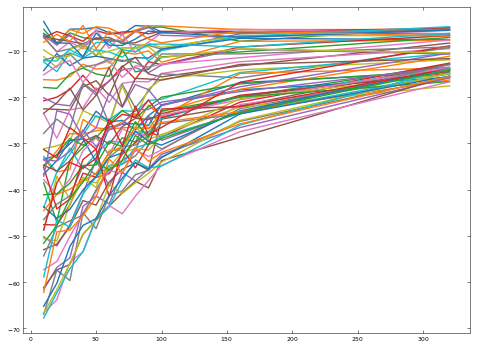

In [405]:
rowResponses = []

for r in range(heightSeqCube.shape[1]):
    highs = [np.min(e[r,:]) for e in heightSeqCube]
    rowResponses.append(highs)
    plt.plot(heights, highs)

plt.show()

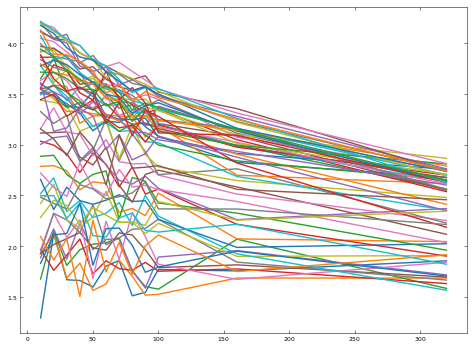

In [406]:
for resp in rowResponses:
    plt.plot(heights, np.log(np.abs(resp)))

plt.show()